In [5]:
from scipy.io import loadmat
from scipy.io import savemat 
import numpy as np
import matplotlib.pyplot as plt
from alphacsc import GreedyCDL
from alphacsc.utils import split_signal
from scipy import signal
from scipy.signal import butter, filtfilt
from matplotlib import gridspec
import time
from alphacsc import BatchCDL

In [6]:
def butter_lowpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def butter_highpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y

In [8]:
#################################################################
## all parameters are set here
#################################################################
ori_fs             = 1000 # Original sampling rate (Hz)
decimate           = 10   # dec factor for analysis data
HI_PASS            = 2    #Hz 
LOW_PASS           = 30   #Hz
fs                 = ori_fs // decimate  # decimated signal fs
n_atoms            = 12
ATOM_DURATION      = 3    # seconds
N_JOBS             = 80   # cdl jobs


In [10]:
#filepath = '/data/sheng/MEG_source_data/case_0390/set2/parcel_ts/set2_parc2018yeo17_200_1000_weighted.npy'
#filepath = '/data/sheng/MEG_source_data/case_0390/set3/parcel_ts/set3_parc2018yeo17_200_1000_weighted.npy'
filepath = '/data/sheng/MEG_source_data/case_0390/set4/parcel_ts/set4_parc2018yeo17_200_1000_weighted.npy'
parcelTS           = np.load(filepath) # data: channels x samples

In [11]:
# visualize the traces

VISUALIZE_TRACES = False

if VISUALIZE_TRACES:     
    BLOCK_SIZE = 5 # Seconds
    BLOCK_N    = 15
    plt.figure(figsize=(20, 25))
    for i in range(BLOCK_N):
        plt.subplot(BLOCK_N, 1, i+1)

        # gray: orig TS
        plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
                 aParcelTS[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k', alpha=0.33)

        # black: filtered data
        plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
                 highpass[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k')

        # red: filtered and decimated
        plt.plot(np.linspace(0, BLOCK_SIZE, fs*BLOCK_SIZE), data[i*fs*BLOCK_SIZE:(i+1)*fs*BLOCK_SIZE], 'r')
    

In [12]:
PARC_N       = parcelTS.shape[0]
SAMPLE_N     = signal.decimate(parcelTS[0], decimate).shape[0]
bpTS         = np.zeros([PARC_N, SAMPLE_N])


# band-pass the data, and decimate if need be #######################
for i in np.arange(0,200):
    
    aParcelTS            = parcelTS[i]    
    lowpass_data         = butter_lowpass(aParcelTS, LOW_PASS, ori_fs)
    highpass             = butter_highpass(lowpass_data, HI_PASS, ori_fs)
    bpTS[i, :]           = signal.decimate(highpass, decimate)
    
del lowpass_data
print('Band-pass done for the parcel time series, now you can fit it with BatchCDL!')

Band-pass done for the parcel time series, now you can fit it with BatchCDL!


In [18]:
split_parcTS = split_signal(bpTS[None], 8)

# Define the shape of the dictionary
n_times_atom = int(round(fs * ATOM_DURATION)) 
print('Data shape:', split_parcTS.shape, '; n_times_atom: ', n_times_atom)


cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=10, random_state=0, n_jobs=N_JOBS)



######################################### FIT IT
print('Start fitting now ...')
t1 = time.time()
cdl.fit(split_parcTS)
del split_parcTS   
######################################### FIT IT

t2 = time.time()

print('\nN of atoms: ', n_atoms, ', Num of Jobs: ', N_JOBS)
print('Low: ', LOW_PASS, 'Hz, High:', HI_PASS, 'Hz')
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t2))}")
print('Time spent:', (t2-t1)/60, ' mins.' )

Data shape: (8, 200, 7662) ; n_times_atom:  300
Start fitting now ...
[BatchCDL] CD iterations 0 / 100
[BatchCDL] lambda = 2.494e+01
[BatchCDL] Objective (z) : 6.062e+06 (sparsity: 2.490e-03)
[BatchCDL] Objective (d) : 6.032e+06
[BatchCDL] CD iterations 1 / 100
[BatchCDL] Objective (z) : 6.010e+06 (sparsity: 3.074e-03)
[BatchCDL] Objective (d) : 5.998e+06
[BatchCDL] CD iterations 2 / 100
[BatchCDL] Objective (z) : 5.989e+06 (sparsity: 3.136e-03)
[BatchCDL] Objective (d) : 5.982e+06
[BatchCDL] CD iterations 3 / 100
[BatchCDL] Objective (z) : 5.977e+06 (sparsity: 3.194e-03)
[BatchCDL] Objective (d) : 5.973e+06
[BatchCDL] CD iterations 4 / 100
[BatchCDL] Objective (z) : 5.970e+06 (sparsity: 3.230e-03)
[BatchCDL] Objective (d) : 5.967e+06
[BatchCDL] CD iterations 5 / 100
[BatchCDL] Objective (z) : 5.965e+06 (sparsity: 3.245e-03)
[BatchCDL] Objective (d) : 5.963e+06
[BatchCDL] CD iterations 6 / 100
[BatchCDL] Objective (z) : 5.961e+06 (sparsity: 3.243e-03)
[BatchCDL] Objective (d) : 5.959e+

(12, 300)


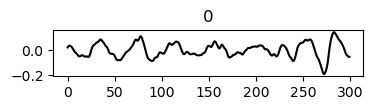

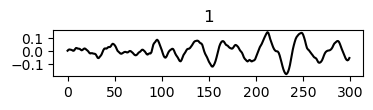

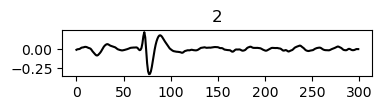

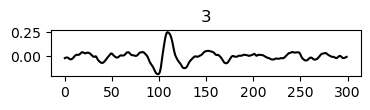

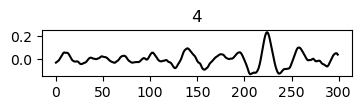

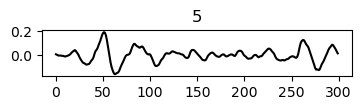

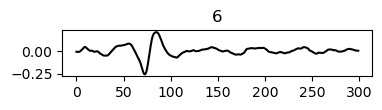

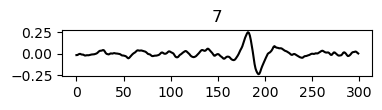

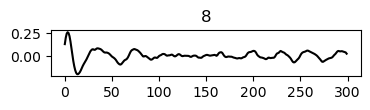

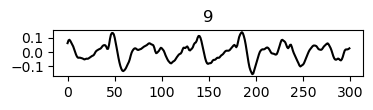

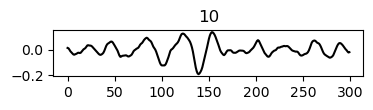

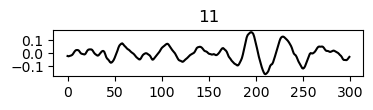

0390_set4_BB_2-30Hz_12_Atoms_3(s).mat


In [22]:
u_hat = cdl.u_hat_ # spatial
v_hat = cdl.v_hat_ # temporal
z_hat = cdl.z_hat_ # scores
print(v_hat.shape)

for i in range(n_atoms):
    plt.figure(figsize=(4, 0.6))
    plt.plot(v_hat[i, :], 'k')
    plt.title(i)
plt.show()

MAT_FILE = filepath[33:37] + '_' + filepath[38:42] + '_BB_' + str(HI_PASS) + '-' + str(LOW_PASS) + 'Hz_' + str(n_atoms) + '_Atoms_' + str(ATOM_DURATION) + '(s).mat'
savemat('./mat_files/' + MAT_FILE, {"u_hat": u_hat, "v_hat": v_hat, 'z_hat': z_hat})
print(MAT_FILE)

In [27]:
#z_hat[0].shape
z_hat.shape[1]

12

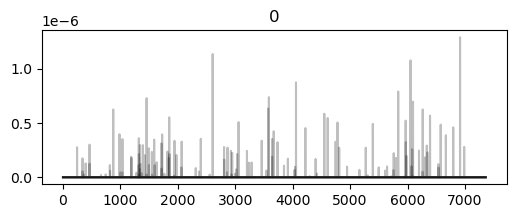

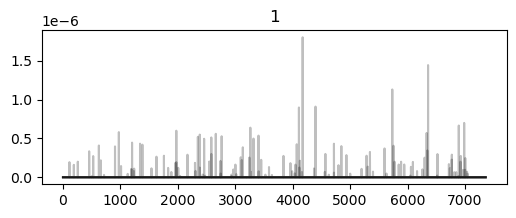

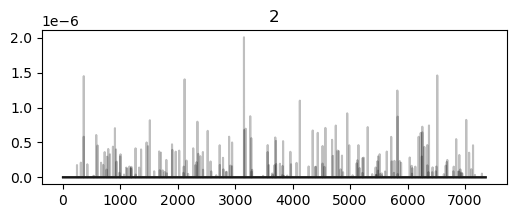

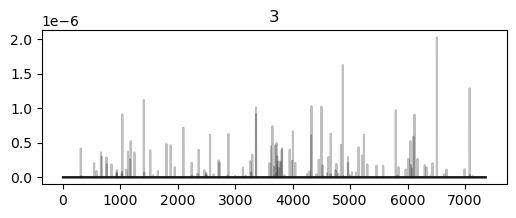

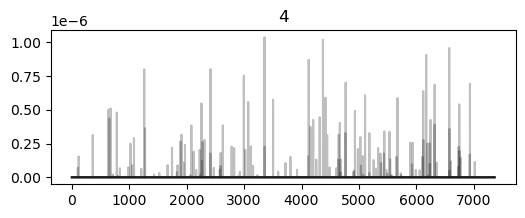

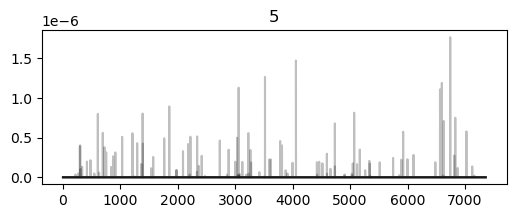

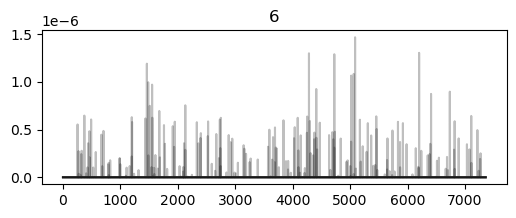

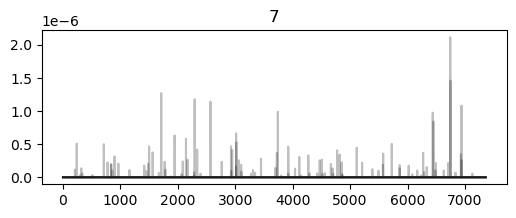

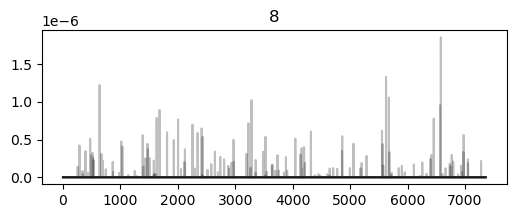

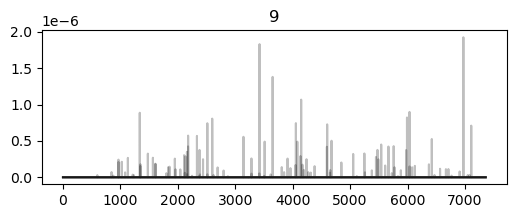

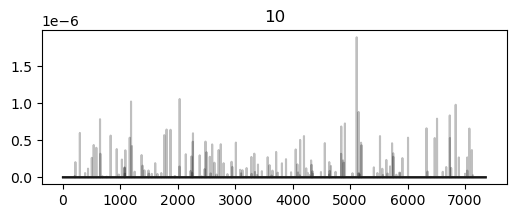

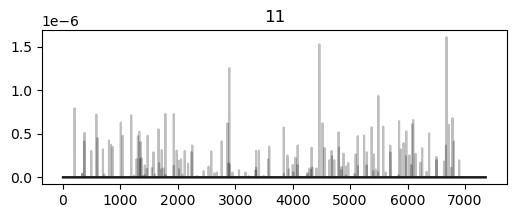

In [28]:
for i in np.arange(z_hat.shape[1]):    
    plt.figure(figsize=(6, 2))
    plt.plot(z_hat[:, i, :].T, 'k', alpha=0.25) 
    plt.title(i)
    
plt.show()

In [ ]:
values = u_hat.shape[9]
# axes should be a 2x2 numpy array
fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2)

# the actual plotting function. 
draw_four_views(axes, values, surf_parcel_names, brain_3d_surfaces, cmap=CMAP, norm_values=Z_LIM)
print(freq_bank[IDX], ' Hz')